In [1]:
from fastai.vision.all import *
import torchaudio
from sklearn.model_selection import StratifiedKFold


In [2]:
df_train = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/train.csv')
df_test = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/test.csv')
submission = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/sample_submission.csv')

In [3]:
train_path = Path('/home/ubuntu/.kaggle/resampled/resampled_train/')
test_path = Path('/home/ubuntu/.kaggle/resampled/resampled_test/')

In [4]:
train_files = get_files(train_path, extensions='.wav')


In [5]:
train_files

(#19909) [Path('/home/ubuntu/.kaggle/resampled/resampled_train/018663_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/008647_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/018904_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/001706_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/003820_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/013023_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/009569_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/017429_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/008264_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/000141_16k.wav')...]

In [6]:
def get_y(filename):
    resample_name = filename.name.split('_')[0] + '.ogg'
    return df_train[df_train['filename']==resample_name]['genre'].values[0]

In [7]:
get_y(train_files[0])


'Chiptune / Glitch'

In [8]:
# Excluded unusual music thanks to this thread: https://www.kaggle.com/c/kaggle-pog-series-s01e02/discussion/312842
def get_items(path): 
    excluded_files = ["010449_16k.wav" , "005589_16k.wav" , "004921_16k.wav", "019511_16k.wav" , "013375_16k.wav" , "024247_16k.wav", "024156_16k.wav"]
    items = get_files(path, extensions='.wav')
    items = [item for item in items if item.name not in excluded_files]
    
    ## For fast iteration
#     items = [item for item in items if get_y(item) in ['Punk', 'Rock']]
    
#     items.shuffle()
    return L(items)

In [9]:
N_FFT = 2048
HOP_LEN = 512

In [10]:
filename = train_files[0]


In [11]:
filename.name.split('_')[0] + '.ogg'


'018663.ogg'

In [12]:
def create_spectrogram(filename):
    audio, sr = torchaudio.load(filename)
    specgram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, 
                                                    n_fft=N_FFT, 
                                                    win_length=N_FFT, 
                                                    hop_length=HOP_LEN*2,
                                                    center=True,
                                                    pad_mode="reflect",
                                                    power=2.0,
                                                    norm='slaney',
                                                    onesided=True,
                                                    n_mels=128,
                                                    mel_scale="htk"
                                                   )(audio)[0]
    specgram = torchaudio.transforms.AmplitudeToDB()(specgram)
    specgram = specgram - specgram.min()
    specgram = specgram/specgram.max()*255
    
    
    return specgram

In [13]:
filename = train_files[0]
spec_default = create_spectrogram(filename)

In [14]:
spec_default.shape


torch.Size([128, 469])

In [15]:
items = get_items(train_path)
labels = [get_y(item) for item in items]
count = Counter(labels)

In [16]:
test_items = get_items(test_path)

In [17]:
splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=labels)

In [18]:
kf = StratifiedKFold(n_splits=8, shuffle=True)

In [19]:
splits_kfold=[]
for _, val_idx in kf.split(np.array(items), labels):
    splits = IndexSplitter(val_idx)
    split = splits(items)
    split_list = [split[0], split[1]]
    splits_kfold.append(split_list)

In [20]:
def alter_learner(learn, channels=1):
    learn.model[0][0][0].in_channels=channels
    learn.model[0][0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0][0].weight[:,1,:,:].unsqueeze(1))

In [21]:
def genreid_from_genre(genre):
    return int(genre2id[genre2id['genre'] == genre]['genre_id'].values[0])

In [22]:
# wgts = [draw_pct[dsets.vocab[label]] for img, label in dsets.train]

In [23]:
draw_pct = {k:1/v for (k, v) in count.items()}

In [24]:
draw_pct

{'Chiptune / Glitch': 0.000847457627118644,
 'International': 0.0012285012285012285,
 'Punk': 0.0003874467260751647,
 'Hip-Hop': 0.0005698005698005698,
 'Ambient Electronic': 0.001256281407035176,
 'Electronic': 0.00032562683165092806,
 'Folk': 0.0008244023083264633,
 'Country': 0.007042253521126761,
 'Rock': 0.00032310177705977385,
 'Experimental': 0.0005558643690939411,
 'Pop': 0.0010582010582010583,
 'Instrumental': 0.0009587727708533077,
 'Classical': 0.00202020202020202,
 'Old-Time / Historic': 0.0024509803921568627,
 'Jazz': 0.0032679738562091504,
 'Spoken': 0.010638297872340425,
 'Soul-RnB': 0.010638297872340425,
 'Blues': 0.017241379310344827,
 'Easy Listening': 0.07692307692307693}

In [25]:
class CustomDataBlock(DataBlock):
    def datasets(self:DataBlock, source, verbose=False, splits=None):
        self.source = source                     ; pv(f"Collecting items from {source}", verbose)
        items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
        if splits is None:
            splits = (self.splitter or RandomSplitter())(items)
        else:
            splits = splits
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        return Datasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)
    def dataloaders(self, source, path='.', verbose=False, splits=None, **kwargs):
        dsets = self.datasets(source, verbose=verbose, splits=splits)
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)

In [26]:
def get_preds(splits_1fold, nb_epoch=45):
    
    db = CustomDataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=create_spectrogram,
        get_y=get_y,
        item_tfms=[Resize(128)],
        batch_tfms=aug_transforms(max_rotate=0, max_warp=0,size=128))
    
    wgts = [draw_pct[label] for label in L(labels)[splits_1fold[0]]]
    dls = db.dataloaders(items, splits=splits_1fold, dl_type=WeightedDL, wgts=wgts)
    
    mixup = MixUp(0.4)
    model = partial(xse_resnext50, pool=MaxPool, act_cls=Mish)
    
    learn = cnn_learner(dls, 
                        model, 
                        metrics=[accuracy, F1Score(average='micro')], 
                        pretrained=False, 
                        loss_func=LabelSmoothingCrossEntropy(), 
                        opt_func=ranger, 
                       )
    
    learn.to_fp16()
    nchannels = dls.one_batch()[0].shape[1]
    alter_learner(learn, nchannels)
    
    learn.fit_flat_cos(nb_epoch, 0.003, cbs=[mixup, CSVLogger(fname=f'history_{int(time.time())}.csv'), ShowGraphCallback()])
    
    test_dl = dls.test_dl(test_items)
    preds = learn.get_preds(dl=test_dl)
    return preds, learn


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.015041,2.725797,0.221865,0.221865,02:18
1,2.625832,2.465771,0.294212,0.294212,02:18
2,2.502200,2.686411,0.366961,0.366961,02:16
3,2.351952,2.460066,0.268891,0.268891,02:20
4,2.248015,2.170644,0.368167,0.368167,02:16
5,2.156848,2.056906,0.393087,0.393087,02:16
6,2.122908,2.173110,0.338023,0.338023,02:16
7,2.076901,2.013061,0.416399,0.416399,02:17
8,2.044363,2.071053,0.395096,0.395096,02:16
9,2.023349,2.036136,0.395498,0.395498,02:16


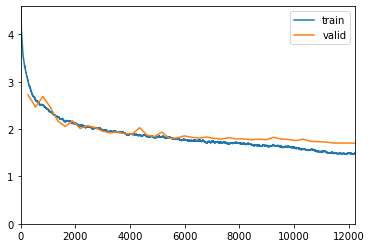

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.998399,2.662271,0.256029,0.256029,02:18
1,2.601975,3.131222,0.342444,0.342444,02:17
2,2.482480,2.686286,0.255225,0.255225,02:17
3,2.361136,2.279947,0.299839,0.299839,02:17
4,2.276199,2.523860,0.274518,0.274518,02:17


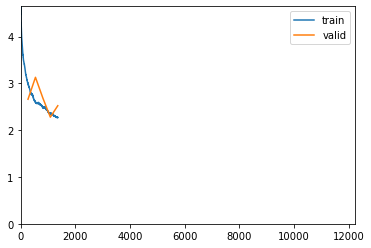

In [ ]:
preds_kfold_learns = [get_preds(split_1fold) for split_1fold in splits_kfold[:2]]

In [201]:
splits_kfold

[[(#15921) [0,1,2,3,4,5,6,7,9,12...],
  (#3981) [8,10,11,15,21,23,34,38,40,43...]],
 [(#15921) [0,2,3,4,7,8,9,10,11,12...],
  (#3981) [1,5,6,17,19,28,30,32,35,36...]],
 [(#15922) [0,1,2,3,5,6,7,8,9,10...],
  (#3980) [4,12,13,14,16,18,29,31,37,45...]],
 [(#15922) [1,4,5,6,7,8,10,11,12,13...],
  (#3980) [0,2,3,9,20,22,24,25,39,44...]],
 [(#15922) [0,1,2,3,4,5,6,8,9,10...],
  (#3980) [7,26,27,33,41,47,49,51,61,66...]]]

In [198]:
dls.train_ds

(#15922) [(PILImage mode=F size=469x128, TensorCategory(3)),(PILImage mode=F size=469x128, TensorCategory(16)),(PILImage mode=F size=469x128, TensorCategory(7)),(PILImage mode=F size=469x128, TensorCategory(16)),(PILImage mode=F size=469x128, TensorCategory(7)),(PILImage mode=F size=469x128, TensorCategory(14)),(PILImage mode=F size=469x128, TensorCategory(2)),(PILImage mode=F size=469x128, TensorCategory(14)),(PILImage mode=F size=469x128, TensorCategory(6)),(PILImage mode=F size=469x128, TensorCategory(16))...]

In [196]:
len(dls.get_idxs())

15922

In [101]:
(0.562563 + 0.564070 + 0.574623 + 0.562312 + 0.570603)/5

0.5668342

In [28]:
preds_kfold = [pred_learn[0] for pred_learn in preds_kfold_learns]
learns = [pred_learn[1] for pred_learn in preds_kfold_learns]

In [32]:
preds_kfold = [np.array(preds[0]) for preds in preds_kfold]

In [33]:
preds_list = [pred.argmax(axis=1) for pred in preds_kfold]

In [34]:
preds_array = np.array(preds_list)

In [35]:
preds_array

array([[ 6,  8,  6, ..., 10,  6,  9],
       [ 6, 14,  6, ..., 10,  6,  9]])

In [36]:
values, counts = np.unique(preds_array,axis=0, return_counts=True)

In [37]:
Counter(preds_array[:,0]).most_common(1)[0][0]

6

In [38]:
preds_array.shape

(2, 5076)

In [39]:
final_votes = [Counter(preds_array[:,i]).most_common(1)[0][0] for i in range(preds_array.shape[1])]

In [26]:
final_preds = np.array(preds_kfold).mean(axis=0)

In [34]:
submission[submission['song_id']=="024013"]

,song_id,genre_id


In [45]:
# preds_idx = final_preds.argmax(axis=1)
genre2id = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/genres.csv')
songid_preds = {int(file_path.name.split('_')[0]):genreid_from_genre(learns[0].dls.vocab[_id]) for file_path, _id in zip(test_items,final_votes)}
submission['genre_id'] = submission['song_id'].map(songid_preds)
submission['genre_id'].fillna(0, inplace=True)
submission.loc[submission['song_id']==22612, 'genre_id'] = 1
submission.loc[submission['song_id']==24013, 'genre_id'] = 0

submission.genre_id = submission.genre_id.astype(int)
submission.to_csv(f"submission_final_{int(time.time())}.csv", index=False)